# C. elegans life cycle model (including dauers)

In [1]:
# !pip install mesa 'prompt-toolkit==1.0.15' # For google CoLab

## Defining the model

In [2]:
# Additional functions for model
def p_enter_dauers(T, density):
    '''Probability of entering dauers'''
    if density > 5.0:
        return 1.0
    else:
        return 0.2

def p_exit_dauers(T, density):
    '''Probability of exiting dauers per hour'''
    return 0.001*(1-p_enter_dauers(T, density))

def p_die_in_dauers(T, density):
    '''Probability of dying in dauers per hour'''
    return 0.00001

def sample_p(p):
    if np.random.rand() <= p:
        return True
    else:
        return False
    
def growth_rate(stage, T):
    '''1/(hours until next stage)'''
    return 1./10.

def n_eggs(T):
    '''number of offspring as a function of temperature. Assuming this is set at birth.'''
    return 10.

def max_rate(T):
    '''maximum eggs/hour as a function of temperature.'''
    return 5.0

def egg_rate(stage, T):
    '''Birth rate per hour at a given stage as an integer'''
    return 1


def temp_schedule(hour):
    '''termperature in celcius as a function of the day'''
    return 20.

In [3]:
# Additional functions for collecting data 
# ...

In [5]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random

# Model
class cElegansWorld(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height, temp_function):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.hour = 0
        self.temp_function = temp_function
        
        # Create agents
        for i in range(self.num_agents):
            a = cElegans(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini},  # A function to call
            agent_reporters={"Stage": "stage", 
                             "Dauers": "dauers",
                             "Check": "check_dauers"})      # An agent attribute 
    
    def temp(self):
        return self.temp_function(self.hour)
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.hour += 1

# Agent 
class cElegans(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = 0 # in hours
        self.stage = 0.0 
        self.check_dauers = False
        self.dauers = False
        self.radius = 3.0
        self.speed = 5
        self.n_eggs = n_eggs(model.temp)
        
    def lay_egg(self):
        self.model.num_agents += 1
        a = cElegans(self.model.num_agents, self.model)
        self.model.schedule.add(a)
        possible_locations = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        birth_location = random.choice(possible_locations)
        self.model.grid.place_agent(a, birth_location)
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False, radius=self.speed)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def enter_dauers(self):
        T0 = self.model.temp()
        return sample_p(p_enter_dauers(T0, self.find_local_density()))
        
    def exit_dauers(self):
        T0 = self.model.temp()
        return sample_p(p_exit_dauers(T0, self.find_local_density()))
    
    def die_in_dauers(self):
        T0 = self.model.temp()
        return sample_p(p_die_in_dauers(T0, self.find_local_density()))
        
    def find_local_density(self):
        neighbors = self.model.grid.get_neighbors(self.pos, self.radius, False)
        return(len(neighbors) / (np.pi * self.radius**2))

    def step(self):
        T0 = self.model.temp()
        
        # 1. Move
        if (self.stage >= 1) &  ~self.dauers:
            self.move()
        
        # 2. Enter/exit dauers, reproduce, or die
        if (self.stage >= 3) & (self.stage < 4): # Dauers
            if not self.check_dauers:
                if self.enter_dauers():
                    self.dauers = True
                self.check_dauers = True
            if self.dauers & self.exit_dauers():
                self.dauers = False
                self.stage = 4.0
            if self.dauers & self.die_in_dauers():
                self.model.schedule.remove(self)
        elif (self.stage >= 5) & (self.stage < 8): # Reproductive Stages
            for _ in range(egg_rate(self.stage, T0)):
                if self.n_eggs > 0:
                    self.lay_egg()
                    self.n_eggs +- 1
        elif self.stage >= 8: # Death
            self.model.schedule.remove(self)
        
        # 3. Advance time 
        self.age += 1
        if not self.dauers:
            self.stage += growth_rate(self.stage, T0)        

In [14]:
model = cElegansWorld(10, 10, 10, temp_schedule)

## Plots 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook
plt.ion()

<IPython.core.display.Javascript object>


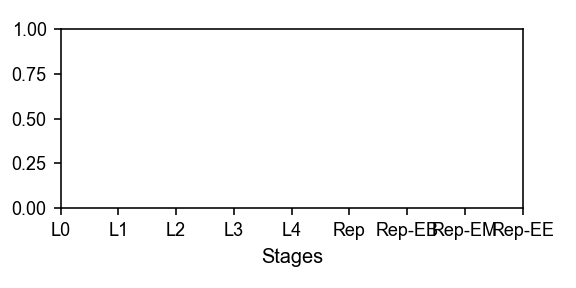

In [3]:
fig1,ax1 = plt.subplots(figsize=(4,2))
stages = ['L0', 'L1', 'L2', 'L3', 'L4', 'Rep', 'Rep-EB', 'Rep-EM', 'Rep-EE']
ax1.set_xticks(range(len(stages)))
ax1.set_xticklabels(stages)
ax1.set_xlabel('Stages')
fig1.tight_layout()
fig1.show()

<IPython.core.display.Javascript object>


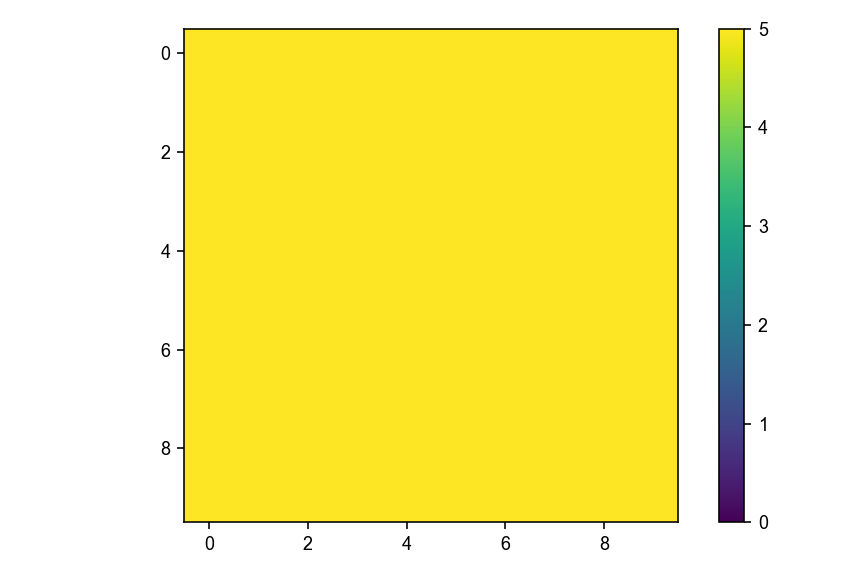

In [19]:
fig2, ax2 = plt.subplots()
agent_counts = np.zeros((model.grid.width, model.grid.height))
image = ax2.imshow(agent_counts, interpolation='nearest')
cbar = plt.colorbar(image)
fig2.tight_layout()
fig2.show()

<IPython.core.display.Javascript object>


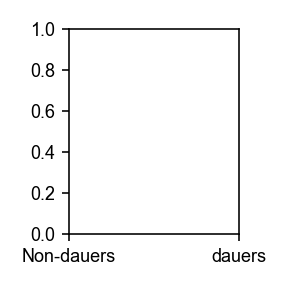

In [4]:
fig3, ax3 = plt.subplots(figsize=(2,2))
labels = ['Non-dauers', 'dauers']
ax3.set_xticks(range(len(labels)))
ax3.set_xticklabels(labels)
fig3.tight_layout()
fig3.show()

## Running the Model

In [20]:
from time import sleep
N_LOOPS = 1000
SLEEP_TIME = 0.2

for i in range(N_LOOPS):    
    # Step model
    model.step()
    
    # Collect Data
    ag = model.datacollector.get_agent_vars_dataframe()
    
    # Figure 1
    ax1.cla()
    ax1.hist(ag.loc[i]["Stage"], color='.9', bins=range(10))
    ax1.set_xticks(range(len(stages)))
    ax1.set_xticklabels(stages)
    ax1.set_xlabel('Stages')
    fig1.tight_layout()
    fig1.canvas.draw()
     
    # Figure 2
    RANGE = 5
    ax2.cla()
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    image = ax2.imshow(agent_counts, interpolation='nearest')
    image.set_clim([0, RANGE])
    cbar.set_clim(vmin=0, vmax=RANGE)
    cbar_ticks = np.linspace(0., RANGE, num=RANGE+1, endpoint=True)
    cbar.set_ticks(cbar_ticks) 
    cbar.draw_all() 
    fig2.tight_layout()
    fig2.canvas.draw()
    
    # Figure 3
    ax3.cla()
    N = len(ag.loc[i]["Dauers"])
    N_D = np.sum(ag.loc[i]["Dauers"])
    N_ND = N - N_D
    ax3.bar([0, 1], [N_ND, N_D], color='.9')
    ax3.set_xticks(range(len(labels)))
    ax3.set_xticklabels(labels)
    fig3.tight_layout()
    fig3.canvas.draw()

    # Pause model
    sleep(SLEEP_TIME)

KeyboardInterrupt: 